In [1006]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [1007]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

# load data
file_path = "./TrainDataset2024.xls"
df = pd.read_excel(file_path)

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 121 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(12), object(1)
memory usage: 378.2+ KB
None
       pCR (outcome)  RelapseFreeSurvival (outcome)         Age          ER  \
count     400.000000                     400.000000  400.000000  400.000000   
mean       12.697500                      56.000208   51.804674    0.547500   
std       111.107417                      27.137584   10.948522    0.498362   
min         0.000000                       0.000000   23.000000    0.000000   
25%         0.000000                      38.000000   44.516769    0.000000   
50%         0.000000                      55.000000   51.019507    1.000000   
75%         0.000000                      73.000000   60.000000    1.000000   
max       999.000000                     144.000000   79.603012    1.000000   

              PgR        HER2  TrippleNegative  ChemoGrade  Proliferation  \
count  400.0000

In [1008]:
# Step 1: missing values
# replace 999 with NaN
df.replace(999, np.nan, inplace=True)
print(df.isnull().sum())

# imputation of Gene
print(f"Ratio of missing value in Gene is {df['Gene'].isnull().sum() / df['Gene'].count()}")
df['Gene'] = df['Gene'].fillna(-1)

# make sure no missing in pCR
df = df[df['pCR (outcome)'].isin([0, 1])]
# drop RFS
df.drop(columns="RelapseFreeSurvival (outcome)",inplace=True)

# categorical imputation
categorical_features = ['ER', 'PgR','HER2', 'TrippleNegative', 'ChemoGrade','Proliferation','HistologyType','LNStatus','TumourStage', 'Gene']
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_features] = imputer_cat.fit_transform(df[categorical_features])

# numerical Imputation
numerical_features = [col for col in df.columns if col not in categorical_features + ['ID', 'pCR (outcome)']]
imputer_num = KNNImputer(n_neighbors=5)
df[numerical_features] = imputer_num.fit_transform(df[numerical_features])

ID                                                     0
pCR (outcome)                                          5
RelapseFreeSurvival (outcome)                          0
Age                                                    0
ER                                                     0
PgR                                                    1
HER2                                                   1
TrippleNegative                                        1
ChemoGrade                                             3
Proliferation                                          2
HistologyType                                          3
LNStatus                                               1
TumourStage                                            0
Gene                                                  88
original_shape_Elongation                              0
original_shape_Flatness                                0
original_shape_LeastAxisLength                         0
original_shape_MajorAxisLength 

In [1009]:
# Check imbalance 
print(f"Ratio of '1' in pCR is {(df['pCR (outcome)']==1).sum() / df['pCR (outcome)'].count()}")

Ratio of '1' in pCR is 0.21265822784810126


In [1010]:
from sklearn.impute import KNNImputer

# Step 2: 异常值检测和处理
# 使用箱线图法检测异常值（示例以 Tumour Proliferation 为例）
for col in numerical_features:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # 替换异常值为边界值
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


In [1011]:
# Step 3: Data Standardization
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

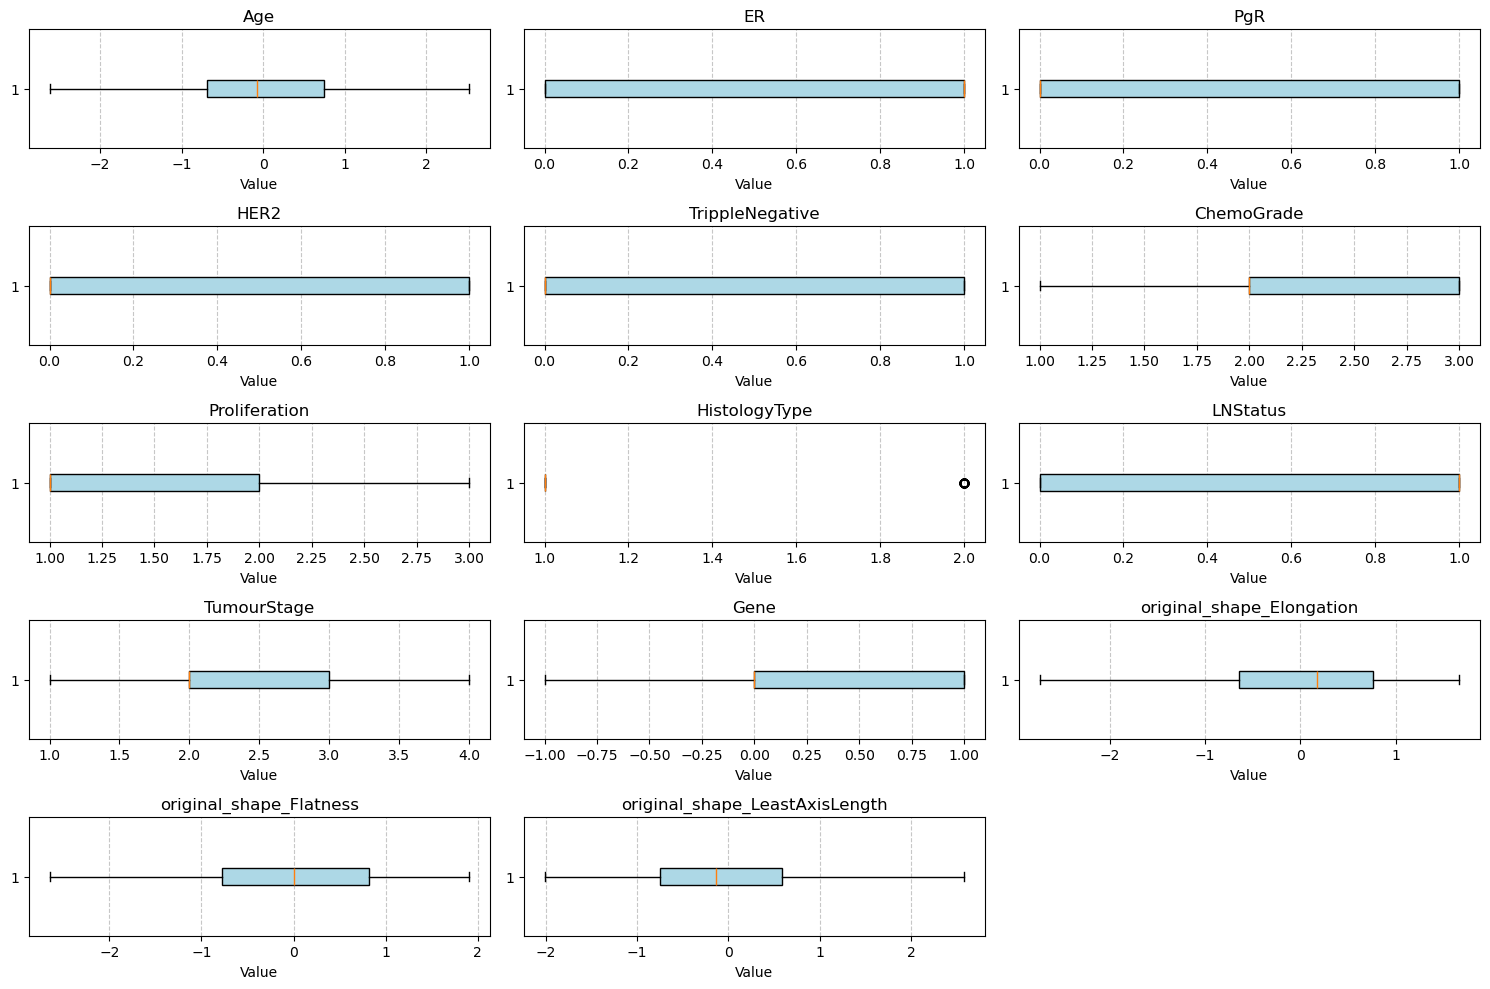

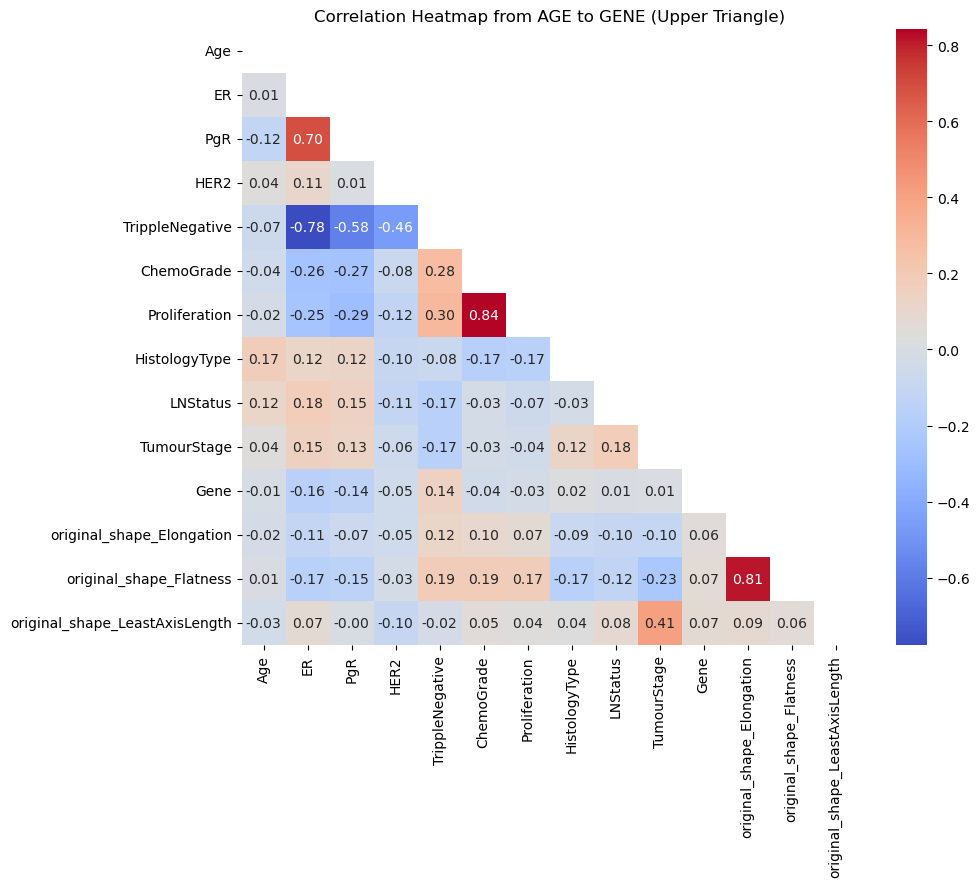

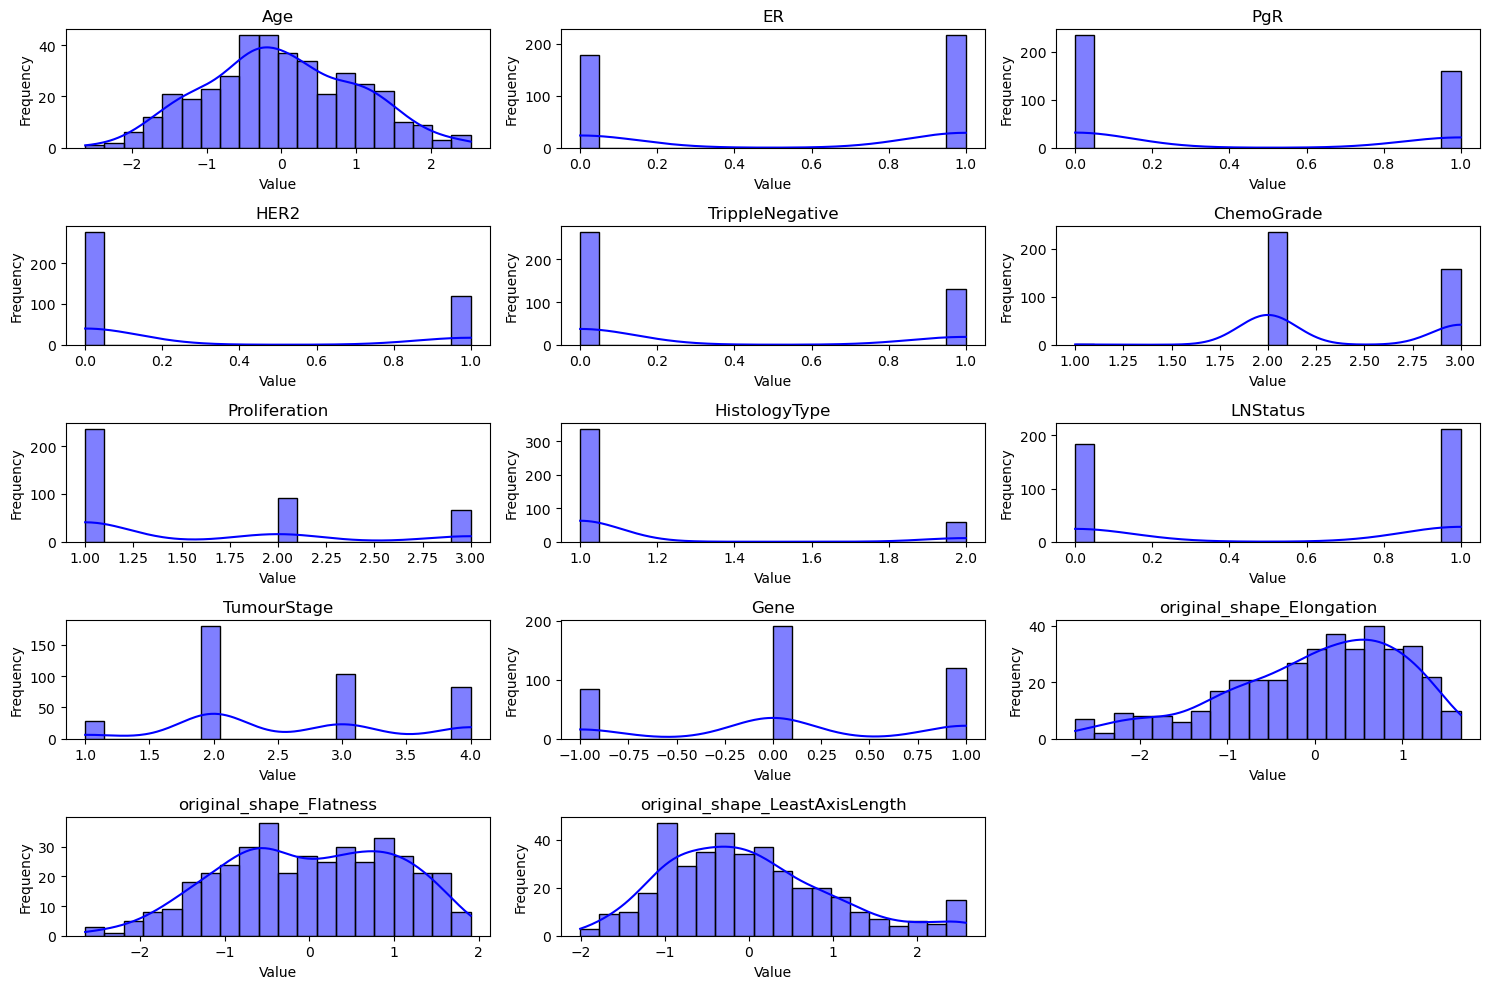

In [1012]:
# from AGE to GENE
selected_columns = df.loc[:, 'Age':'original_shape_LeastAxisLength']

# Step 1: 绘制箱线图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    plt.boxplot(selected_columns[col].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(col)
    plt.xlabel('Value')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Step 2: 绘制相关性热图
# 计算相关性矩阵
corr_matrix = selected_columns.corr()
# 使用 Seaborn 绘制热成像分布图
plt.figure(figsize=(10, 8))
# 创建掩码
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# 使用 Seaborn 绘制热成像分布图（仅上三角）
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap from AGE to GENE (Upper Triangle)")
plt.show()

# Step 3: 绘制直方图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    sns.histplot(selected_columns[col], kde=True, color='blue', bins=20)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [1013]:
# Step 4: 数据划分
# 提取特征和目标变量
X = df.drop(columns=['ID', 'pCR (outcome)']) 
y = df['pCR (outcome)']

# 按 8:2 分层划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [1014]:
# SMOTE
from imblearn.over_sampling import SMOTE,BorderlineSMOTE,SMOTENC,ADASYN
from imblearn.combine import SMOTETomek

#smote = SMOTETomek()
#smote = ADASYN(random_state=42,sampling_strategy='minority')
smote = SMOTENC(categorical_features = categorical_features, random_state=42)
#smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", np.bincount(y_train_resampled))

Class distribution after SMOTE: [249 249]


C:\Users\22519\AppData\Local\Temp\ipykernel_18340\309135352.py:10: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print("Class distribution after SMOTE:", np.bincount(y_train_resampled))


In [1015]:
# Step 5: 检查处理结果
print("PCR 训练集:", X_train_resampled.shape, "验证集:", X_val.shape)

PCR 训练集: (498, 118) 验证集: (79, 118)


In [ ]:
# Step 6: Build Baseline Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

print("Before SMOTE")
# Model 0-1: LogisticRegression
baseline_lr = LogisticRegression(max_iter = 500,random_state=42)
baseline_lr.fit(X_train, y_train)
logistic_y_pred = baseline_lr.predict(X_val)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val, logistic_y_pred))

# Model 0-2: RandomForestClassifier
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train, y_train)
random_y_pred = baseline_rf.predict(X_val)
print("\nRandom Forest- Classification Report:")
print(classification_report(y_val, random_y_pred))
print("After SMOTE")

# Model 1: LogisticRegression
baseline_lr = LogisticRegression(max_iter = 500,random_state=42)
baseline_lr.fit(X_train_resampled, y_train_resampled)
logistic_y_pred = baseline_lr.predict(X_val)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val, logistic_y_pred))

# Model 2: RandomForestClassifier
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train_resampled, y_train_resampled)
random_y_pred = baseline_rf.predict(X_val)
print("\nRandom Forest- Classification Report:")
print(classification_report(y_val, random_y_pred))

Before SMOTE

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.90      0.84        62
         1.0       0.14      0.06      0.08        17

    accuracy                           0.72        79
   macro avg       0.46      0.48      0.46        79
weighted avg       0.64      0.72      0.67        79


Random Forest- Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87        62
         1.0       0.40      0.12      0.18        17

    accuracy                           0.77        79
   macro avg       0.60      0.53      0.52        79
weighted avg       0.71      0.77      0.72        79

After SMOTE

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80        62
         1.0       0.28      0.29      0.29        17

    accuracy              

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# Step 7: Building models

# Model 1: RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced', n_estimators=75,random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
rf_y_pred = rf.predict(X_val)
print("\nRandom Forest- Classification Report:")
print(classification_report(y_val, rf_y_pred))

# Extract feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display ranked features
print(feature_importances)

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

print("ROC-AUC:")
cross_val_results = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=kf,scoring="roc_auc")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())

print("\nAccuracy:")
cross_val_results = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=kf,scoring="accuracy")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Accruacy Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())



Random Forest- Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85        62
         1.0       0.40      0.24      0.30        17

    accuracy                           0.76        79
   macro avg       0.61      0.57      0.58        79
weighted avg       0.72      0.76      0.73        79

                                               Feature  Importance
10                                                Gene    0.049205
3                                                 HER2    0.031433
2                                                  PgR    0.024993
1                                                   ER    0.015676
91     original_glrlm_RunLengthNonUniformityNormalized    0.014557
83                    original_glrlm_GrayLevelVariance    0.014106
12                             original_shape_Flatness    0.014049
21                           original_shape_Sphericity    0.012857
39                        origi

In [1018]:
from sklearn.model_selection import cross_val_score, KFold

# Model 1: LogisticRegression
lr = LogisticRegression(C=1.2,max_iter=500,solver='liblinear',class_weight='balanced',random_state=42)
lr.fit(X_train_resampled, y_train_resampled)
lr_y_pred = lr.predict(X_val)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val, lr_y_pred))

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

print("ROC-AUC:")
cross_val_results = cross_val_score(lr, X_train_resampled, y_train_resampled, cv=kf,scoring="roc_auc")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())

print("\nAccuracy:")
cross_val_results = cross_val_score(lr, X_train_resampled, y_train_resampled, cv=kf,scoring="accuracy")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Accruacy Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())



Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80        62
         1.0       0.28      0.29      0.29        17

    accuracy                           0.68        79
   macro avg       0.54      0.54      0.54        79
weighted avg       0.69      0.68      0.69        79

ROC-AUC:
Cross-Validation Results: [0.90304487 0.87025704 0.87353535 0.85726005 0.83511075]
Mean Score: 0.867841611801626
Variance of model performance: 0.0004921603003383995

Accuracy:
Cross-Validation Results: [0.8        0.82       0.81       0.80808081 0.80808081]
Mean Accruacy Score: 0.8092323232323233
Variance of model performance: 4.088399142944563e-05


Threshold: 0.1, Precision: 0.29, Recall: 0.76, F1: 0.42
Threshold: 0.2, Precision: 0.29, Recall: 0.59, F1: 0.39
Threshold: 0.3, Precision: 0.36, Recall: 0.53, F1: 0.43
Threshold: 0.4, Precision: 0.33, Recall: 0.41, F1: 0.37
Threshold: 0.5, Precision: 0.28, Recall: 0.29, F1: 0.29
Threshold: 0.6, Precision: 0.29, Recall: 0.24, F1: 0.26
Threshold: 0.7, Precision: 0.22, Recall: 0.12, F1: 0.15
Threshold: 0.8, Precision: 0.17, Recall: 0.06, F1: 0.09
Threshold: 0.9, Precision: 0.25, Recall: 0.06, F1: 0.10


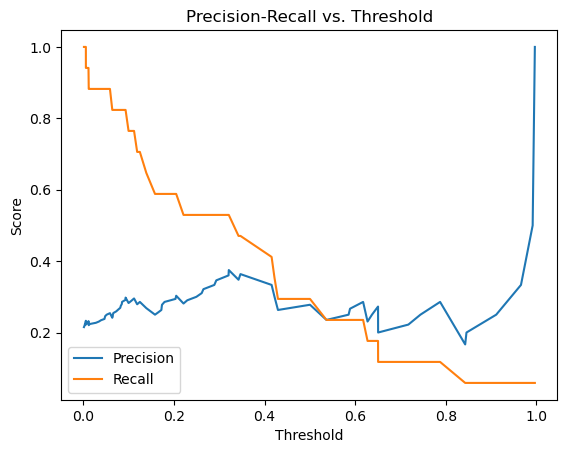

Best Threshold: 0.32105417505779776, Best F1-Score: 0.43902439024390244
Best Threshold (Youden's J): 0.09321653522246955


In [1019]:
from sklearn.metrics import precision_score, recall_score, f1_score,precision_recall_curve
from sklearn.metrics import roc_curve

# 对 theroshold 进行调整可以进行precision和recall的取舍，可以根据具体需求调整
# thershold tuning
y_probs = lr.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)  # Convert probabilities to binary predictions
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print(f"Threshold: {threshold:.1f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Plot the curve
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Precision-Recall vs. Threshold')
plt.show()

best_threshold = 0
best_f1 = 0
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1}")

# Get false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_probs)

# Compute Youden's J statistic
j_scores = tpr - fpr
best_threshold = thresholds[np.argmax(j_scores)]
print(f"Best Threshold (Youden's J): {best_threshold}")

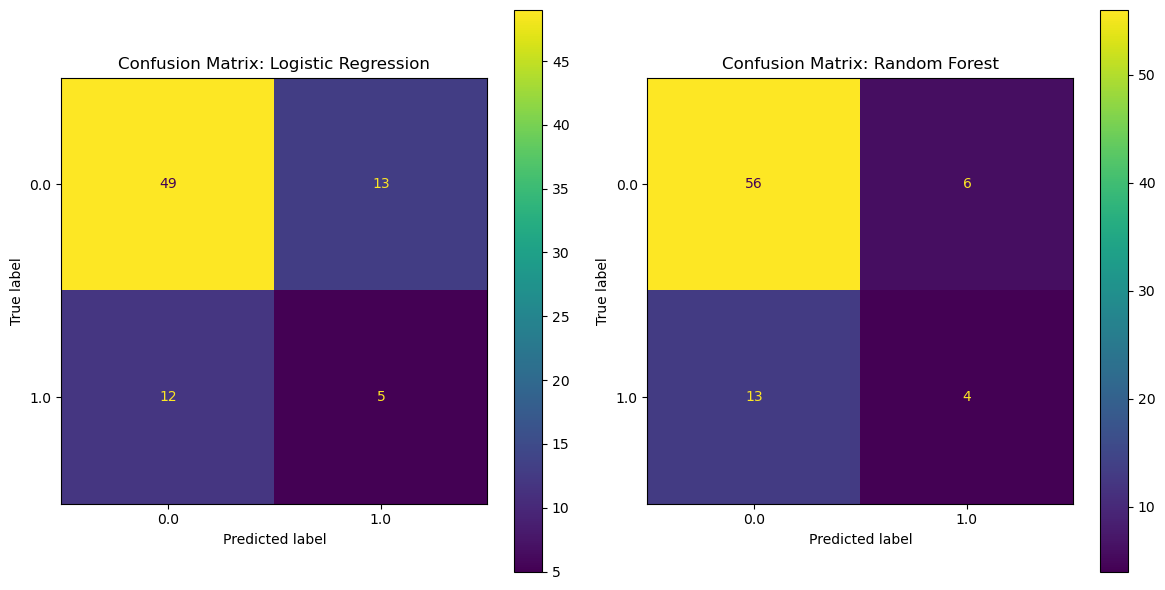

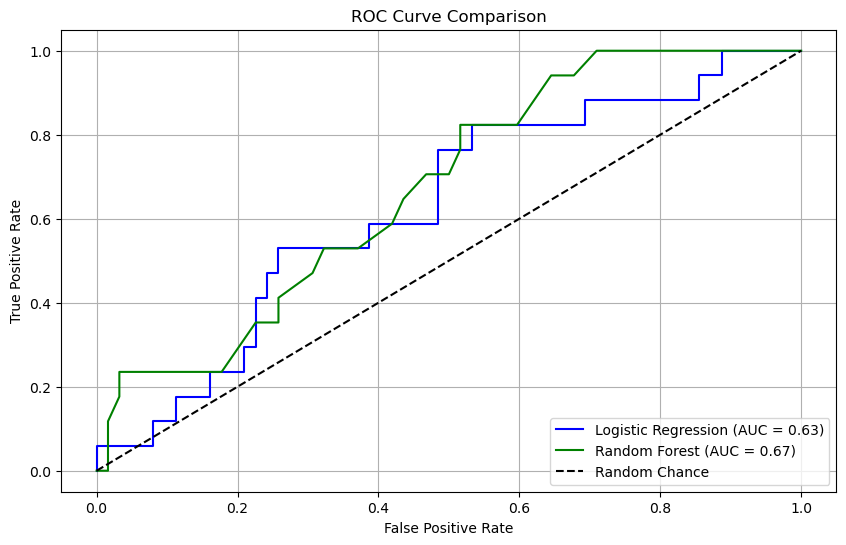

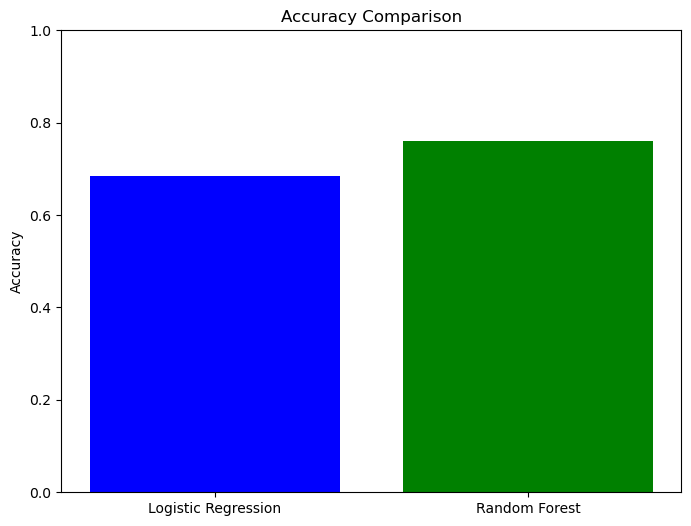

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, ConfusionMatrixDisplay, accuracy_score

# 1: Predictions and Probabilities for Logistic Regression
logistic_y_prob = baseline_lr.predict_proba(X_val)[:, 1]  # Probabilities for ROC
logistic_accuracy = accuracy_score(y_val, lr_y_pred)

# 2: Predictions and Probabilities for Random Forest
random_y_prob = baseline_rf.predict_proba(X_val)[:, 1]  # Probabilities for ROC
random_accuracy = accuracy_score(y_val, rf_y_pred)

# 3: Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay.from_predictions(y_val, lr_y_pred, ax=ax[0])
ax[0].set_title('Confusion Matrix: Logistic Regression')

ConfusionMatrixDisplay.from_predictions(y_val, rf_y_pred, ax=ax[1])
ax[1].set_title('Confusion Matrix: Random Forest')

plt.tight_layout()
plt.show()

# Step 4: ROC Curves 
logistic_fpr, logistic_tpr, _ = roc_curve(y_val, logistic_y_prob)
random_fpr, random_tpr, _ = roc_curve(y_val, random_y_prob)

logistic_auc = auc(logistic_fpr, logistic_tpr)
random_auc = auc(random_fpr, random_tpr)

plt.figure(figsize=(10, 6))
plt.plot(logistic_fpr, logistic_tpr, label=f'Logistic Regression (AUC = {logistic_auc:.2f})', color='blue')
plt.plot(random_fpr, random_tpr, label=f'Random Forest (AUC = {random_auc:.2f})', color='green')

# Diagonal for random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Plot settings
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Step 5: Bar Chart for Accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Logistic Regression', 'Random Forest'], [logistic_accuracy, random_accuracy], color=['blue', 'green'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


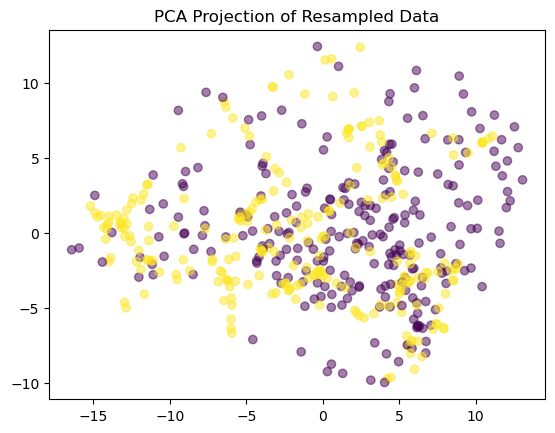

In [1021]:
from sklearn.decomposition import PCA

# 数据重叠严重，模型难以辨别
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_resampled, cmap='viridis', alpha=0.5)
plt.title("PCA Projection of Resampled Data")
plt.show()


In [1022]:
from sklearn.metrics import roc_auc_score

# Model 1: LogisticRegression
lr = LogisticRegression(C=1.2,max_iter=500,solver='liblinear',class_weight='balanced',random_state=42)
lr.fit(X_train_resampled, y_train_resampled)
lr_y_pred = lr.predict(X_val)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val, lr_y_pred))

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Metrics
y_pred = lr.predict(X_val)
y_prob = lr.predict_proba(X_val)[:, 1]  # For ROC-AUC
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_prob)

# Display Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")



Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80        62
         1.0       0.28      0.29      0.29        17

    accuracy                           0.68        79
   macro avg       0.54      0.54      0.54        79
weighted avg       0.69      0.68      0.69        79

Accuracy: 0.6835
Precision: 0.2778
Recall: 0.2941
F1-Score: 0.2857
ROC-AUC: 0.6271


In [1023]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
import numpy as np

# Function to compute bias and variance
def compute_bias_variance(model, X, y, cv=5):
    # Initialize arrays to store predictions and targets
    all_predictions = np.zeros(len(y))
    fold_predictions = []
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train the model and predict on the test fold
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Store predictions in their correct positions
        all_predictions[test_idx] = predictions
        fold_predictions.append(predictions)

    # Convert fold predictions to a numpy array
    fold_predictions = np.array([np.concatenate(fold_predictions)])

    # Compute average predictions
    avg_predictions = np.mean(fold_predictions, axis=0)

    # Compute Bias and Variance
    bias = np.mean((y - avg_predictions) ** 2)
    variance = np.mean((fold_predictions - avg_predictions) ** 2)
    return bias, variance

bias, variance = compute_bias_variance(baseline_lr, X_train_resampled, y_train_resampled, cv=5)
print(f"Bias: {bias:.4f}")
print(f"Variance: {variance:.4f}")


Bias: 0.4418
Variance: 0.0000


<Axes: >

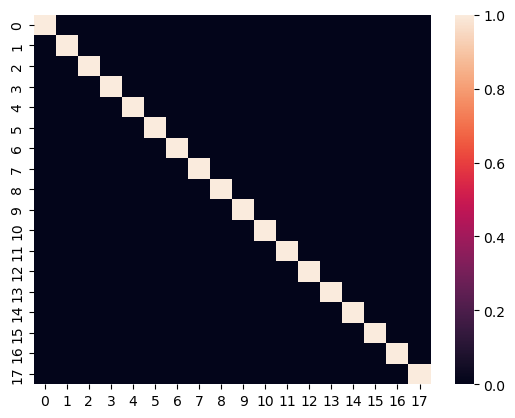

In [1024]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 18)
X_train_pca = pca.fit_transform(X_train_resampled)
X_val_pca = pca.transform(X_val)
X_train_pca = pd.DataFrame(X_train_pca)
X_val_pca = pd.DataFrame(X_val_pca)

X_train_pca.head()
sns.heatmap(X_train_pca.corr())

In [1025]:
# Model 1: LogisticRegression
lr = LogisticRegression(C=1.2,max_iter=500,solver='liblinear',random_state=42)
lr.fit(X_train_pca, y_train_resampled)

y_probs = lr.predict_proba(X_val_pca)[:, 1]
y_pred = (y_probs >= 0.53).astype(int)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val, y_pred))

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

# Display Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
bias, variance = compute_bias_variance(lr, X_train_resampled, y_train_resampled, cv=5)
print(f"Bias: {bias:.4f}")
print(f"Variance: {variance:.4f}")


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82        62
         1.0       0.42      0.65      0.51        17

    accuracy                           0.73        79
   macro avg       0.65      0.70      0.66        79
weighted avg       0.79      0.73      0.75        79

Accuracy: 0.7342
Precision: 0.4231
Recall: 0.6471
F1-Score: 0.5116
ROC-AUC: 0.7026
Bias: 0.4378
Variance: 0.0000


In [1026]:
# Model 1: RandomForestClassifier
rf = RandomForestClassifier(n_estimators=75,random_state=42)
rf.fit(X_train_pca, y_train_resampled)
y_probs = rf.predict_proba(X_val_pca)[:, 1]
rf_y_pred = (y_probs >= 0.38).astype(int)

print("\nRandom Forest- Classification Report:")
print(classification_report(y_val, rf_y_pred))

# Metrics
accuracy = accuracy_score(y_val, rf_y_pred)
precision = precision_score(y_val, rf_y_pred)
recall = recall_score(y_val, rf_y_pred)
f1 = f1_score(y_val, rf_y_pred)
roc_auc = roc_auc_score(y_val, rf_y_pred)

# Display Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
bias, variance = compute_bias_variance(lr, X_train_resampled, y_train_resampled, cv=5)
print(f"Bias: {bias:.4f}")
print(f"Variance: {variance:.4f}")


Random Forest- Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78        62
         1.0       0.39      0.71      0.50        17

    accuracy                           0.70        79
   macro avg       0.64      0.70      0.64        79
weighted avg       0.79      0.70      0.72        79

Accuracy: 0.6962
Precision: 0.3871
Recall: 0.7059
F1-Score: 0.5000
ROC-AUC: 0.6997
Bias: 0.4378
Variance: 0.0000
